# Question 3

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# updating the keras version for importing ops module in the following
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [ ]:
import os
import keras
from keras import Model
from keras.layers import Flatten, Dense
from keras.applications.resnet50 import ResNet50
from keras.datasets import cifar10
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import ops
import numpy as np
from keras.models import load_model
import keras_tuner as kt

## Construct `Distiller()` class

The custom `Distiller()` class, overrides the `Model` methods `compile`, `compute_loss`,
and `call`. In order to use the distiller, we need:

- A trained teacher model
- A student model to train
- A student loss function on the difference between student predictions and ground-truth
- A distillation loss function, along with a `temperature`, on the difference between the
soft student predictions and the soft teacher labels
- An `alpha` factor to weight the student and distillation loss
- An optimizer for the student and (optional) metrics to evaluate performance

In the `compute_loss` method, we perform a forward pass of both the teacher and student,
calculate the loss with weighting of the `student_loss` and `distillation_loss` by `alpha`
and `1 - alpha`, respectively. Note: only the student weights are updated.

In [ ]:
# distiller class
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def compute_loss(
        self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False
    ):
        teacher_pred = self.teacher(x, training=False)
        student_loss = self.student_loss_fn(y, y_pred)

        distillation_loss = self.distillation_loss_fn(
            ops.softmax(teacher_pred / self.temperature, axis=1),
            ops.softmax(y_pred / self.temperature, axis=1),
        ) * (self.temperature**2)

        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        return loss

    def call(self, x):
        return self.student(x)


## Prepare the dataset

The dataset used for training the teacher and distilling the teacher is
Cifar10. Both the student and teacher are trained on the training set and evaluated on the test set.

In [ ]:
num_classes = 10
batch_size = 128

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
# input image dimensions
img_rows, img_cols = 32, 32
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)
print(input_shape)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print("Number of training data: {} \nNumber of test data: {}\nsize of each picture: ({},{})".format(x_train.shape[0],x_test.shape[0],x_train.shape[1],x_train.shape[2]))


(32, 32, 3)
Number of training data: 50000 
Number of test data: 10000
size of each picture: (32,32)


## Create student and teacher models

Initialy, we create a teacher model and a smaller student model. Both models are
convolutional neural networks and created using `Sequential()`,
but could be any Keras model.

In [ ]:
# Create the teacher
ResNet50 = keras.applications.ResNet50(include_top=False,
                weights="imagenet",
                input_shape=input_shape,
                classes=num_classes,
                classifier_activation="softmax")
ResNet50.trainable = False
teacher_out = Flatten()(ResNet50.output)
teacher_out = Dense(num_classes, activation='softmax')(teacher_out)
teacher_model = Model(inputs=ResNet50.input, outputs=teacher_out)
teacher_model.name = 'teacher'
teacher_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "teacher"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Create the student
def model_builder(hp):
    MobileNetV2 = keras.applications.MobileNetV2(include_top=False,
                    weights=None,
                    input_shape=input_shape,
                    classes=num_classes,
                    classifier_activation="softmax")

    student_out = Flatten()(MobileNetV2.output)
    student_out = Dense(num_classes, activation='softmax')(student_out)
    student_model = Model(inputs=MobileNetV2.input, outputs=student_out)
    student_model.name = 'student'
    student_model.summary()

    # Initialize and compile distiller
    distiller = Distiller(student=student_model, teacher=teacher_model)
    distiller.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[keras.metrics.SparseCategoricalAccuracy()],
              student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              distillation_loss_fn=keras.losses.KLDivergence(),
              alpha=hp.Float('alpha', min_value=0, max_value=0.9, step=0.1),
              temperature=hp.Int('temperature', min_value=0, max_value=20, step=1)
    )
    return distiller

## Train the teacher

In knowledge distillation we assume that the teacher is trained and fixed. Thus, we start
by training the teacher model on the training set in the usual way.

Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - loss: 2.5087 - sparse_categorical_accuracy: 0.1188 - val_loss: 2.2375 - val_sparse_categorical_accuracy: 0.1661
Epoch 2/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 2.2219 - sparse_categorical_accuracy: 0.1966 - val_loss: 2.1717 - val_sparse_categorical_accuracy: 0.2343
Epoch 3/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 2.1633 - sparse_categorical_accuracy: 0.2383 - val_loss: 2.1236 - val_sparse_categorical_accuracy: 0.2458
Epoch 4/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 2.1228 - sparse_categorical_accuracy: 0.2545 - val_loss: 2.0835 - val_sparse_categorical_accuracy: 0.2894
Epoch 5/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 2.0864 - sparse_categorical_accuracy: 0.2738 - val_loss: 2.0552 - val_sparse_categorical_accuracy: 0.2775
Epoch 6/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 2.0539 - sparse_categorical_accuracy: 0.2817 - val_loss: 2.0335 - val_sparse_categorical_accuracy: 0.2884
E

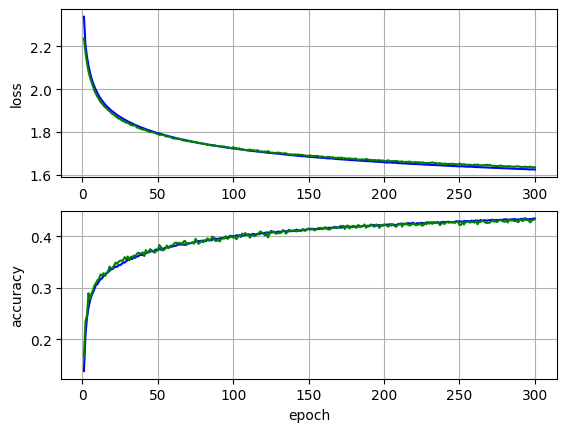

In [ ]:
# Train teacher as usual
teacher_model.compile(
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=[keras.metrics.SparseCategoricalAccuracy()]
)
# Train and evaluate teacher on data.
epochs = 300
teacher_history = teacher_model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
# plotting the loss and accuracy per epochs
plt.figure()
plt.subplot(2,1,1);
plt.plot(range(1,epochs+1), teacher_history.history['loss'], 'b',
         range(1,epochs+1), teacher_history.history['val_loss'],'g')
plt.ylabel('loss'); plt.grid()
plt.subplot(2,1,2);
plt.plot(range(1,epochs+1), teacher_history.history['sparse_categorical_accuracy'], 'b',
         range(1,epochs+1), teacher_history.history['val_sparse_categorical_accuracy'],'g')
plt.ylabel('accuracy'); plt.grid(); plt.xlabel('epoch')
plt.show()

In [ ]:
score=teacher_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.6355648040771484
Test accuracy: 0.4334000051021576


In [ ]:
teacher_model.save('model_teacher_HW2_3_6.h5')

### best teacher model
loading my best teacher model and see its result.

> model_teacher_HW2_3_5.h5

> https://drive.google.com/file/d/1-B4VX6mdrmVBNrfoiu6yULyQvr4ZwpqQ/view?usp=drive_link











In [ ]:
teacher_model = load_model('/content/drive/MyDrive/HW2_models/model_teacher_HW2_3_5.h5')
teacher_model.summary()
score=teacher_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "teacher"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,608,204 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 2 (12.00 B)

Test loss: 1.468966007232666
Test accuracy: 0.49219998717308044


## Distill teacher to student

We have already trained the teacher model, and we only need to initialize a
`Distiller(student, teacher)` instance, `compile()` it with the desired losses,
hyperparameters and optimizer, and distill the teacher to the student. I am using **random search** to see what is the best parameter. I first tranied the student model on a small part of the data and for less epochs.

In [ ]:
x = x_train[: 20000]
y = y_train[: 20000]

In [ ]:
# Distill teacher to student
tuner = kt.RandomSearch(
    hypermodel=model_builder,
    objective='val_sparse_categorical_accuracy',
    max_trials=3,
    max_retries_per_trial=1,
    directory='/content/drive/MyDrive',
    project_name='14th_run'
)
tuner.search_space_summary()

tuner.search(x, y,
             batch_size=batch_size,
             epochs=50,
             verbose=1,
             validation_data=(x_test, y_test))

Trial 3 Complete [00h 08m 49s]
val_sparse_categorical_accuracy: 0.10000000149011612

Best val_sparse_categorical_accuracy So Far: 0.10000000149011612
Total elapsed time: 00h 25m 30s


I also printed a summary of the search results.

In [ ]:
tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/14th_run
Showing 10 best trials
Objective(name="val_sparse_categorical_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
alpha: 0.0
temperature: 1
Score: 0.10000000149011612

Trial 1 summary
Hyperparameters:
alpha: 0.7000000000000001
temperature: 5
Score: 0.10000000149011612

Trial 2 summary
Hyperparameters:
alpha: 0.30000000000000004
temperature: 2
Score: 0.10000000149011612


unfortunately the results were thw same for all three trials.I've tried differernt teacher models but there weren't any good results. I wouldn't been able to train the teacher model for large number of epochs, because colab ran out of GPU. but the loss and accuracy plots shows that maybe for more epochs, it will get better.

extracting the best parameters and model.

In [ ]:
# extracting and printing best combination of hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters.values)

{'alpha': 0.0, 'temperature': 1}


In [ ]:
# alpha = 0
# temperature = 1

In [ ]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

Model: "student"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 16, 16, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 16, 16, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 16, 16, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 16, 16, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 16, 16, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 16, 16, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 16, 16, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 16, 16, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 16, 16, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 17, 17, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 8, 8, 96)       │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 2,236,682 (8.53 MB)

 Non-trainable params: 34,112 (133.25 KB)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 322 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# printing the loss and accuracy of the model on testing data
score = best_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0
Test accuracy: 0.0


In the following I create and trained the student model again for more epochs to see if the result get better or not.

<ipython-input-23-31f70d3ea58e>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNetV2 = keras.applications.MobileNetV2(include_top=False,


Model: "student"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 16, 16, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 16, 16, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 16, 16, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 16, 16, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 16, 16, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 16, 16, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 16, 16, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 16, 16, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 16, 16, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 17, 17, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 8, 8, 96)       │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 2,236,682 (8.53 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 96s 120ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.1006 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 0.1000
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.1007 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 0.1000
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.1023 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 0.1000
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.0993 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 0.1000
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.1016 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 0.1000
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.0999 - 

NameError: name 'epochs' is not defined

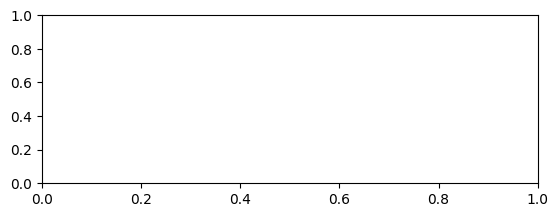

In [ ]:
MobileNetV2 = keras.applications.MobileNetV2(include_top=False,
                weights="imagenet",
                input_shape=input_shape,
                classes=num_classes,
                classifier_activation="softmax")

student_out = Flatten()(MobileNetV2.output)
student_out = Dense(num_classes, activation='softmax')(student_out)
student_model = Model(inputs=MobileNetV2.input, outputs=student_out)
student_model.name = 'student'
student_model.summary()

# Initialize and compile distiller
distiller = Distiller(student=student_model, teacher=teacher_model)
distiller.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
          metrics=[keras.metrics.SparseCategoricalAccuracy()],
          student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          distillation_loss_fn=keras.losses.KLDivergence(),
          alpha=best_hyperparameters.values['alpha'],
          temperature=best_hyperparameters.values['temperature']
)

student_history=distiller.fit(x_train, y_train,
                              batch_size=batch_size,
                              epochs=100,
                              verbose=1,
                              validation_data=(x_test, y_test))


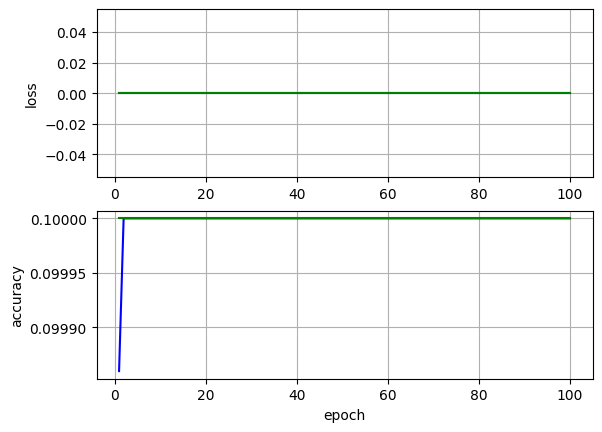

In [ ]:
epochs = 100
# plotting loss and accuracy per epochs
plt.figure()
plt.subplot(2,1,1);
plt.plot(range(1,epochs+1), student_history.history['loss'], 'b',
         range(1,epochs+1), student_history.history['val_loss'],'g')
plt.ylabel('loss'); plt.grid()
plt.subplot(2,1,2);
plt.plot(range(1,epochs+1), student_history.history['sparse_categorical_accuracy'], 'b',
         range(1,epochs+1), student_history.history['val_sparse_categorical_accuracy'],'g')
plt.ylabel('accuracy'); plt.grid(); plt.xlabel('epoch')
plt.show()

In [ ]:
# Evaluate student on test dataset
score=distiller.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0
Test accuracy: 0.0


In [ ]:
distiller.save('student_model_HW2_3_2.h5')

unfortunately because of poor teacher model the student wasn't able to act perfect. the accuracy of the student is 10%(chance) in the training data and zero in test.

### best student model

> student_model_HW2_3_2.h5


> https://drive.google.com/file/d/11qBKcl-qQQWpNssHC4oUn6bf7NG6RNE4/view?usp=sharing






## Train student from scratch for comparison

We can also train an equivalent student model from scratch without the teacher, in order
to evaluate the performance gain obtained by knowledge distillation.

In [ ]:
# converting the train and test labels into one hot format
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
print(y_train.shape)

(10000, 10)
(50000, 10)


<ipython-input-23-a8466abc9c23>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNetV2 = keras.applications.MobileNetV2(include_top=False,


Model: "student_scratch"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 16, 16, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 16, 16, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 16, 16, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 16, 16, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 16, 16, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 16, 16, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 16, 16, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 16, 16, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 16, 16, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 17, 17, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 8, 8, 96)       │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 2,389,130 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 78s 94ms/step - accuracy: 0.4435 - loss: 1.8090 - val_accuracy: 0.1538 - val_loss: 16.3326
Epoch 2/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 23ms/step - accuracy: 0.6395 - loss: 1.0936 - val_accuracy: 0.1876 - val_loss: 8.5376
Epoch 3/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.6747 - loss: 0.9755 - val_accuracy: 0.4550 - val_loss: 5.7748
Epoch 4/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7491 - loss: 0.7314 - val_accuracy: 0.5800 - val_loss: 2.5838
Epoch 5/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.7916 - loss: 0.6072 - val_accuracy: 0.6701 - val_loss: 1.6125
Epoch 6/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.8163 - loss: 0.5370 - val_accuracy: 0.7076 - val_loss: 1.2171
Epoch 7/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.8395 - loss: 0.4712 - val_accuracy: 0.6895 - val_loss: 1.4223
Epoch 8/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.8552 - loss: 0.4

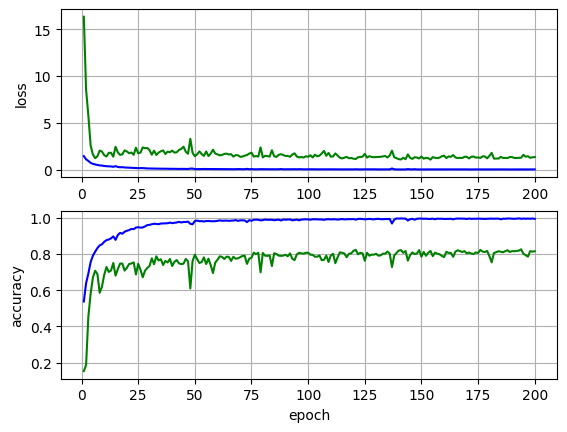

In [ ]:
# Create the student
# loading the mobilenet network
MobileNetV2 = keras.applications.MobileNetV2(include_top=False,
                weights="imagenet",
                input_shape=input_shape,
                classes=num_classes,
                classifier_activation="softmax")
# fully connected layer
student_scratch_out = Flatten()(MobileNetV2.output)
student_scratch_out = Dense(num_classes, activation='softmax')(student_scratch_out)
student_scratch_model = Model(inputs=MobileNetV2.input, outputs=student_scratch_out)
student_scratch_model.name = 'student_scratch'
student_scratch_model.summary()
# Train student
student_scratch_model.compile(
          loss=keras.losses.categorical_crossentropy,
          optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
          metrics=['accuracy']
)
epochs = 200
# Train and evaluate student trained from scratch
student_scratch_history = student_scratch_model.fit(x_train, y_train,
                                                    batch_size=batch_size,
                                                    epochs=epochs,
                                                    verbose=1,
                                                    validation_data=(x_test, y_test))
# plotting the loss and accuracy per epoch
plt.figure()
plt.subplot(2,1,1);
plt.plot(range(1,epochs+1), student_scratch_history.history['loss'], 'b',
         range(1,epochs+1), student_scratch_history.history['val_loss'],'g')
plt.ylabel('loss'); plt.grid()
plt.subplot(2,1,2);
plt.plot(range(1,epochs+1), student_scratch_history.history['accuracy'], 'b',
         range(1,epochs+1), student_scratch_history.history['val_accuracy'],'g')
plt.ylabel('accuracy'); plt.grid(); plt.xlabel('epoch')
plt.show()

In [ ]:
student_scratch_model.save('student_scracth_model_HW2_3_2.h5')

### best from zero student model

loading mybest model to see its result.

> student_scracth_model_HW2_3_1.h5


> https://drive.google.com/file/d/1PRhaYR19ejmZGcO8Xa6F5pzRg2spAf7m/view?usp=drive_link







In [ ]:
from keras.models import load_model
student_scratch_model = load_model('/content/drive/MyDrive/HW2_models/student_scracth_model_HW2_3_1.h5')
student_scratch_model.summary()
# converting the train and test labels into one hot format
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
score=student_scratch_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "student_scratch"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 16, 16, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 16, 16, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 16, 16, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 16, 16, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 16, 16, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 16, 16, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 16, 16, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 16, 16, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 16, 16, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 17, 17, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 8, 8, 96)       │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,423,244 (9.24 MB)

 Trainable params: 2,389,130 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 2 (12.00 B)

(10000, 10)
(50000, 10)
Test loss: 1.338636040687561
Test accuracy: 0.8151000142097473


unexpectedly the result for the student model from zero is the best one. it got to 80% accuracy.

# sites

https://keras.io/api/applications/mobilenet/

https://keras.io/api/applications/resnet/#resnet50-function

https://keras.io/api/datasets/cifar10/

https://keras.io/examples/vision/knowledge_distillation/

https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class

https://keras.io/guides/keras_tuner/getting_started/#getting-started-with-kerastuner
